# Committor
Reference paper: 
_Kang, Trizio and Parrinello, [ArXiv](https://arxiv.org/abs/2401.05279) (2024)_


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/committor/docs/notebooks/tutorials/adv_committor.ipynb)

## Setup

In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh TUTORIAL', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)
torch.set_default_dtype(torch.float64)

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Initialize committor model and training variables

In [2]:
from mlcolvar.cvs.committor import Committor,initialize_committor_masses

# temperature
T = 1 
# Boltzmann factor in the RIGHT ENREGY UNITS!
kb = 1
beta = 1/(kb*T)
print(f'Beta: {beta} \n1/beta: {1/beta}')

atomic_masses = initialize_committor_masses(atoms_map=[[1,1]], n_dims=2)

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR
options = {'optimizer' : {'lr': 1e-3, 'weight_decay': 1e-5}, 
           'lr_scheduler' : { 'scheduler' : lr_scheduler, 'gamma' : 0.99999 } }

model = Committor(layers = [2, 32, 32, 1],
                    mass = atomic_masses,
                    alpha = 1e-1,
                    delta_f=0,
                    options=options)

Beta: 1.0 
1/beta: 1.0


# Load data

In [3]:
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.cvs.committor import compute_committor_weights

################################### SET THINGS HERE ###################################
folder = None
filenames = ['data/muller-brown/unbiased/state-0/COLVAR',
             'data/muller-brown/unbiased/state-1/COLVAR',
             'data/muller-brown/biased/committor/iter_1/COLVAR_A',
             'data/muller-brown/biased/committor/iter_1/COLVAR_B',
             'data/muller-brown/biased/committor/iter_2/COLVAR_A',
             'data/muller-brown/biased/committor/iter_2/COLVAR_B'
            ]

load_args = [{'start' : 0, 'stop': 2000, 'stride': 1},
             {'start' : 0, 'stop': 2000, 'stride': 1},
             {'start' : 0, 'stop': 10000, 'stride': 1},
             {'start' : 0, 'stop': 10000, 'stride': 1},
             {'start' : 0, 'stop': 10000, 'stride': 1},
             {'start' : 0, 'stop': 10000, 'stride': 1},
            ]           

# #######################################################################################

dataset, dataframe = create_dataset_from_files(file_names = filenames,
                                               folder = folder,
                                               create_labels = True,
                                               filter_args = {'regex': 'p.x|p.y'}, # to load many positions --> 'regex': 'p[1-9]\.[abc]|p[1-2][0-9]\.[abc]'
                                               return_dataframe = True,
                                               load_args=load_args,
                                               verbose = True)


# compute the weight for the reweighing depending on the simualtions
dataframe, dataset = compute_committor_weights(dataframe=dataframe, dataset=dataset, beta=beta)

# create datamoduel with only training set
datamodule = DictModule(dataset, lengths=[1])

Class 0 dataframe shape:  (2000, 13)
Class 1 dataframe shape:  (2000, 13)
Class 2 dataframe shape:  (10000, 10)
Class 3 dataframe shape:  (10000, 10)
Class 4 dataframe shape:  (10000, 10)
Class 5 dataframe shape:  (10000, 10)

 - Loaded dataframe (44000, 18): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker', 'labels', 'q.node-0', 'q.bias-0', 'bias', 'mueller', 'bias.1']
 - Descriptors (44000, 2): ['p.x', 'p.y']


# Initialize trainer and fit model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss_fn | CommittorLoss | 0      | ?        | ?        
1 | nn      | FeedForward   | 1.2 K  | [1, 2]   | [1, 1]   
-----------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 49.68it/s, v_num=101] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 46.50it/s, v_num=101]


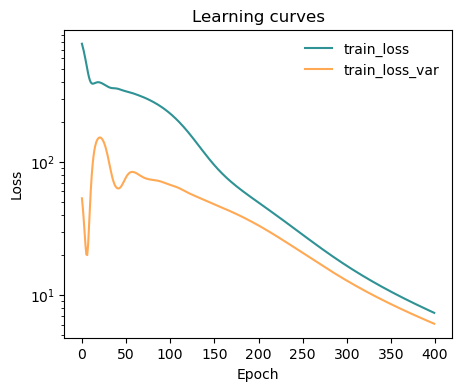

In [4]:
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()

# initialize trainer, for testing the number of epochs is low, change this to sothing like 4/5000
trainer = lightning.Trainer(callbacks=[metrics], max_epochs=4, logger=None, enable_checkpointing=False,
            limit_val_batches=0, num_sanity_val_steps=0
        )

# fit model
trainer.fit(model, datamodule)

# plot metrics
ax = plot_metrics(metrics.metrics,
                  keys=['train_loss', 'train_loss_var'],
                  colors=['fessa1','fessa5'],
                  yscale='log')

# Visualize results

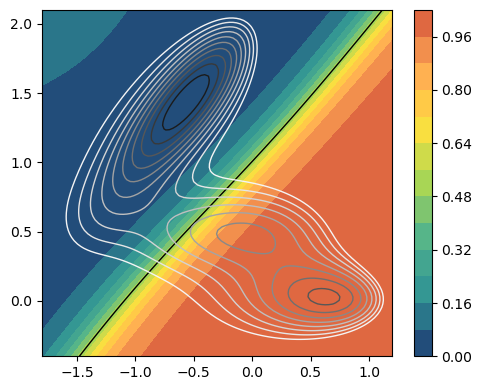

In [5]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
plot_isolines_2D(model, ax=ax, colorbar=True)
plot_isolines_2D(model, ax=ax, colorbar=True, levels=[0.5], mode='contour', linewidths=1)
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
plt.tight_layout()
plt.show()

# Export model with tracing

In [6]:
traced_model = model.to_torchscript(file_path='test_trace.pt', method='trace')

# OPTIONAL: Apply preprocessing to compute descriptors 
You can add preprocessing module to the model by `model.preprocessing = Module`
Here we just create a mock preprocessing that swaps `p.x` and `p.y` 

tensor([[-0.2500,  1.7500],
        [-0.5028,  1.5120]])
tensor([[ 1.7500, -0.2500],
        [ 1.5120, -0.5028]])


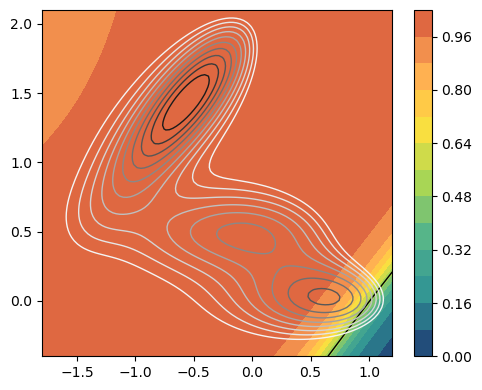

In [8]:
from mlcolvar.core.transform import PairwiseDistances

class UselsessPreprocessing(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = torch.flip(x, (1, ))
        return x

Prep = UselsessPreprocessing()

inp = dataset['data'][0:2]

prep_inp = Prep(inp)

model.preprocessing = Prep
fig, ax = plt.subplots(1,1,figsize=(5,4))
plot_isolines_2D(model, ax=ax, colorbar=True)
plot_isolines_2D(model, ax=ax, colorbar=True, levels=[0.5], mode='contour', linewidths=1)
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
plt.tight_layout()
plt.show()
